# Coronavirus Testing in NYC by Zip Code
### This notebook explores the disparities of coronavirus testing across NYC zip codes
#### Khyatee Desai<br>April 15, 2020

# Data Sets
**1. Population by Zip Code:** http://www.usa.com/rank/new-york-northern-new-jersey-long-island-ny-nj-pa-area--population-density--zip-code-rank.htm?yr=9000&dis=&wist=&plow=&phigh=<br>
**2. Testing by Zip Code:** https://github.com/nychealth/coronavirus-data<br>
**3. NYC Zip Codes Shapefile** https://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas


In [266]:
import re
import csv
import json
from datetime import date
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import geopandas as gpd
import mapclassify

## Data Collection: Population within each Zip Code

In [2]:
# base_url = 'http://www.usa.com/rank/new-york-northern-new-jersey-long-island-ny-nj-pa-area--population-density--zip-code-rank.htm?yr=9000&dis=&wist=&plow=&phigh='
# r = requests.get(base_url)
# outfile = open('popDensity.html', 'w')
# outfile.write(r.text)
# outfile.close()

In [84]:
html = open('popDensity.html','r')
soup = BeautifulSoup(html, "html.parser")
rows = soup.findAll('tr')
to_df = []
for row in rows[2:]:
    columns = row.findAll('td')
    zipPop = columns[2].text
    to_df.append(zipPop.split(' / '))
zip_pop_df = pd.DataFrame(to_df)
zip_pop_df = zip_pop_df.rename(columns={0:'Zip', 1:"Population"})
zip_pop_df
    

,Zip,Population
0,10028,"46,169"
1,10128,"62,447"
2,10075,"24,377"
3,10025,"97,373"
4,10023,"60,762"
...,...,...
878,11430,171
879,07851,106
880,11973,40
881,10911,2


## Data Collection: Number of covid tests within each zip code

In [380]:
test_df = pd.read_csv('test_data.csv')
test_df = test_df.rename(columns={'MODZCTA':'Zip','Positive':'#Positive', 'Total':"#Tested","zcta_cum.perc_pos":"PercentPosTests"})
test_df['Zip'] = test_df['Zip'].astype(str).str.split('.', expand = True)[0]
test_df


,Zip,#Positive,#Tested,PercentPosTests
0,nan,1851,2017,91.77
1,10001,221,462,47.84
2,10002,554,1045,53.01
3,10003,285,678,42.04
4,10004,23,59,38.98
...,...,...,...,...
173,11691,1155,1715,67.35
174,11692,310,493,62.88
175,11693,205,347,59.08
176,11694,371,641,57.88


### Merge the datasets

In [381]:
merged = pd.merge(zip_pop_df, test_df, on='Zip')
merged['Population'] = merged['Population'].str.replace(',','').astype(int)
merged

,Zip,Population,#Positive,#Tested,PercentPosTests
0,10028,46169,326,822,39.66
1,10128,62447,403,1027,39.24
2,10075,24377,265,571,46.41
3,10025,97373,652,1485,43.91
4,10023,60762,350,871,40.18
...,...,...,...,...,...
172,10314,87524,1608,3329,48.30
173,10004,3024,23,59,38.98
174,10309,33382,575,1298,44.30
175,11697,4078,63,132,47.73


## Add columns
#### PercentPopTested = percent of the population within a zip code that has been tested<br>PercentPopPositive = percent of population within a zip code that is positive


In [382]:
merged['PercentPopTested'] = ((merged['#Tested']/merged['Population'])*100).round(2)
merged['PercentPopPositive'] = ((merged['#Positive']/merged['Population'])*100).round(2)
merged.sort_values('Population', ascending=False).head()

,Zip,Population,#Positive,#Tested,PercentPosTests,PercentPopTested,PercentPopPositive
78,11368,110385,2446,3102,78.85,2.81,2.22
50,11220,101715,808,1277,63.27,1.26,0.79
41,11373,100713,1893,2647,71.51,2.63,1.88
107,11385,100132,1091,1839,59.33,1.84,1.09
77,10467,99251,1818,2991,60.78,3.01,1.83


### Visualize with heatmap

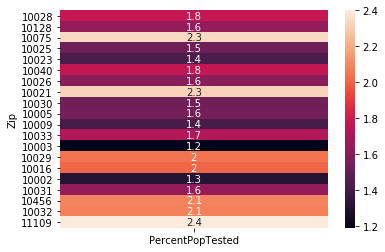

In [358]:
heat = merged[['Zip', 'PercentPopTested']]
heat.set_index('Zip', inplace=True)
sns.heatmap(heat.head(20), annot=True)

# Choropleth Map
### import shapefile for NYC zip codes and create GeoDataFrame with GeoPandas

In [414]:
shapefile = 'zips.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)
gdf.head()

,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry
0,1,11372,Jackson Heights,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.883573,40.751662,"POLYGON ((-73.86942 40.74916, -73.89143 40.746..."
1,2,11004,Glen Oaks,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.711608,40.745366,"POLYGON ((-73.71133 40.74947, -73.71068 40.750..."
2,3,11040,New Hyde Park,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.703443,40.748714,"POLYGON ((-73.70098 40.73890, -73.70309 40.744..."
3,4,11426,Bellerose,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.724004,40.736534,"POLYGON ((-73.72270 40.75373, -73.72251 40.753..."
4,5,11365,Fresh Meadows,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.794626,40.739903,"POLYGON ((-73.81089 40.72717, -73.81116 40.728..."


### Merge covid dataframe with GeoDataFrame

In [415]:
geo_merge = gdf.merge(merged, right_on = 'Zip', left_on = 'postalCode')
geo_merge.head()

,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry,Zip,Population,#Positive,#Tested,PercentPosTests,PercentPopTested,PercentPopPositive
0,1,11372,Jackson Heights,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.883573,40.751662,"POLYGON ((-73.86942 40.74916, -73.89143 40.746...",11372,63202,1476,1992,74.10,3.15,2.34
1,2,11004,Glen Oaks,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.711608,40.745366,"POLYGON ((-73.71133 40.74947, -73.71068 40.750...",11004,14045,330,521,63.34,3.71,2.35
2,4,11426,Bellerose,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.724004,40.736534,"POLYGON ((-73.72270 40.75373, -73.72251 40.753...",11426,19348,301,537,56.05,2.78,1.56
3,5,11365,Fresh Meadows,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.794626,40.739903,"POLYGON ((-73.81089 40.72717, -73.81116 40.728...",11365,43138,457,828,55.19,1.92,1.06
4,6,11373,Elmhurst,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.878423,40.738851,"POLYGON ((-73.88722 40.72753, -73.88721 40.728...",11373,100713,1893,2647,71.51,2.63,1.88



# Plotting
## Population in each Zip Code

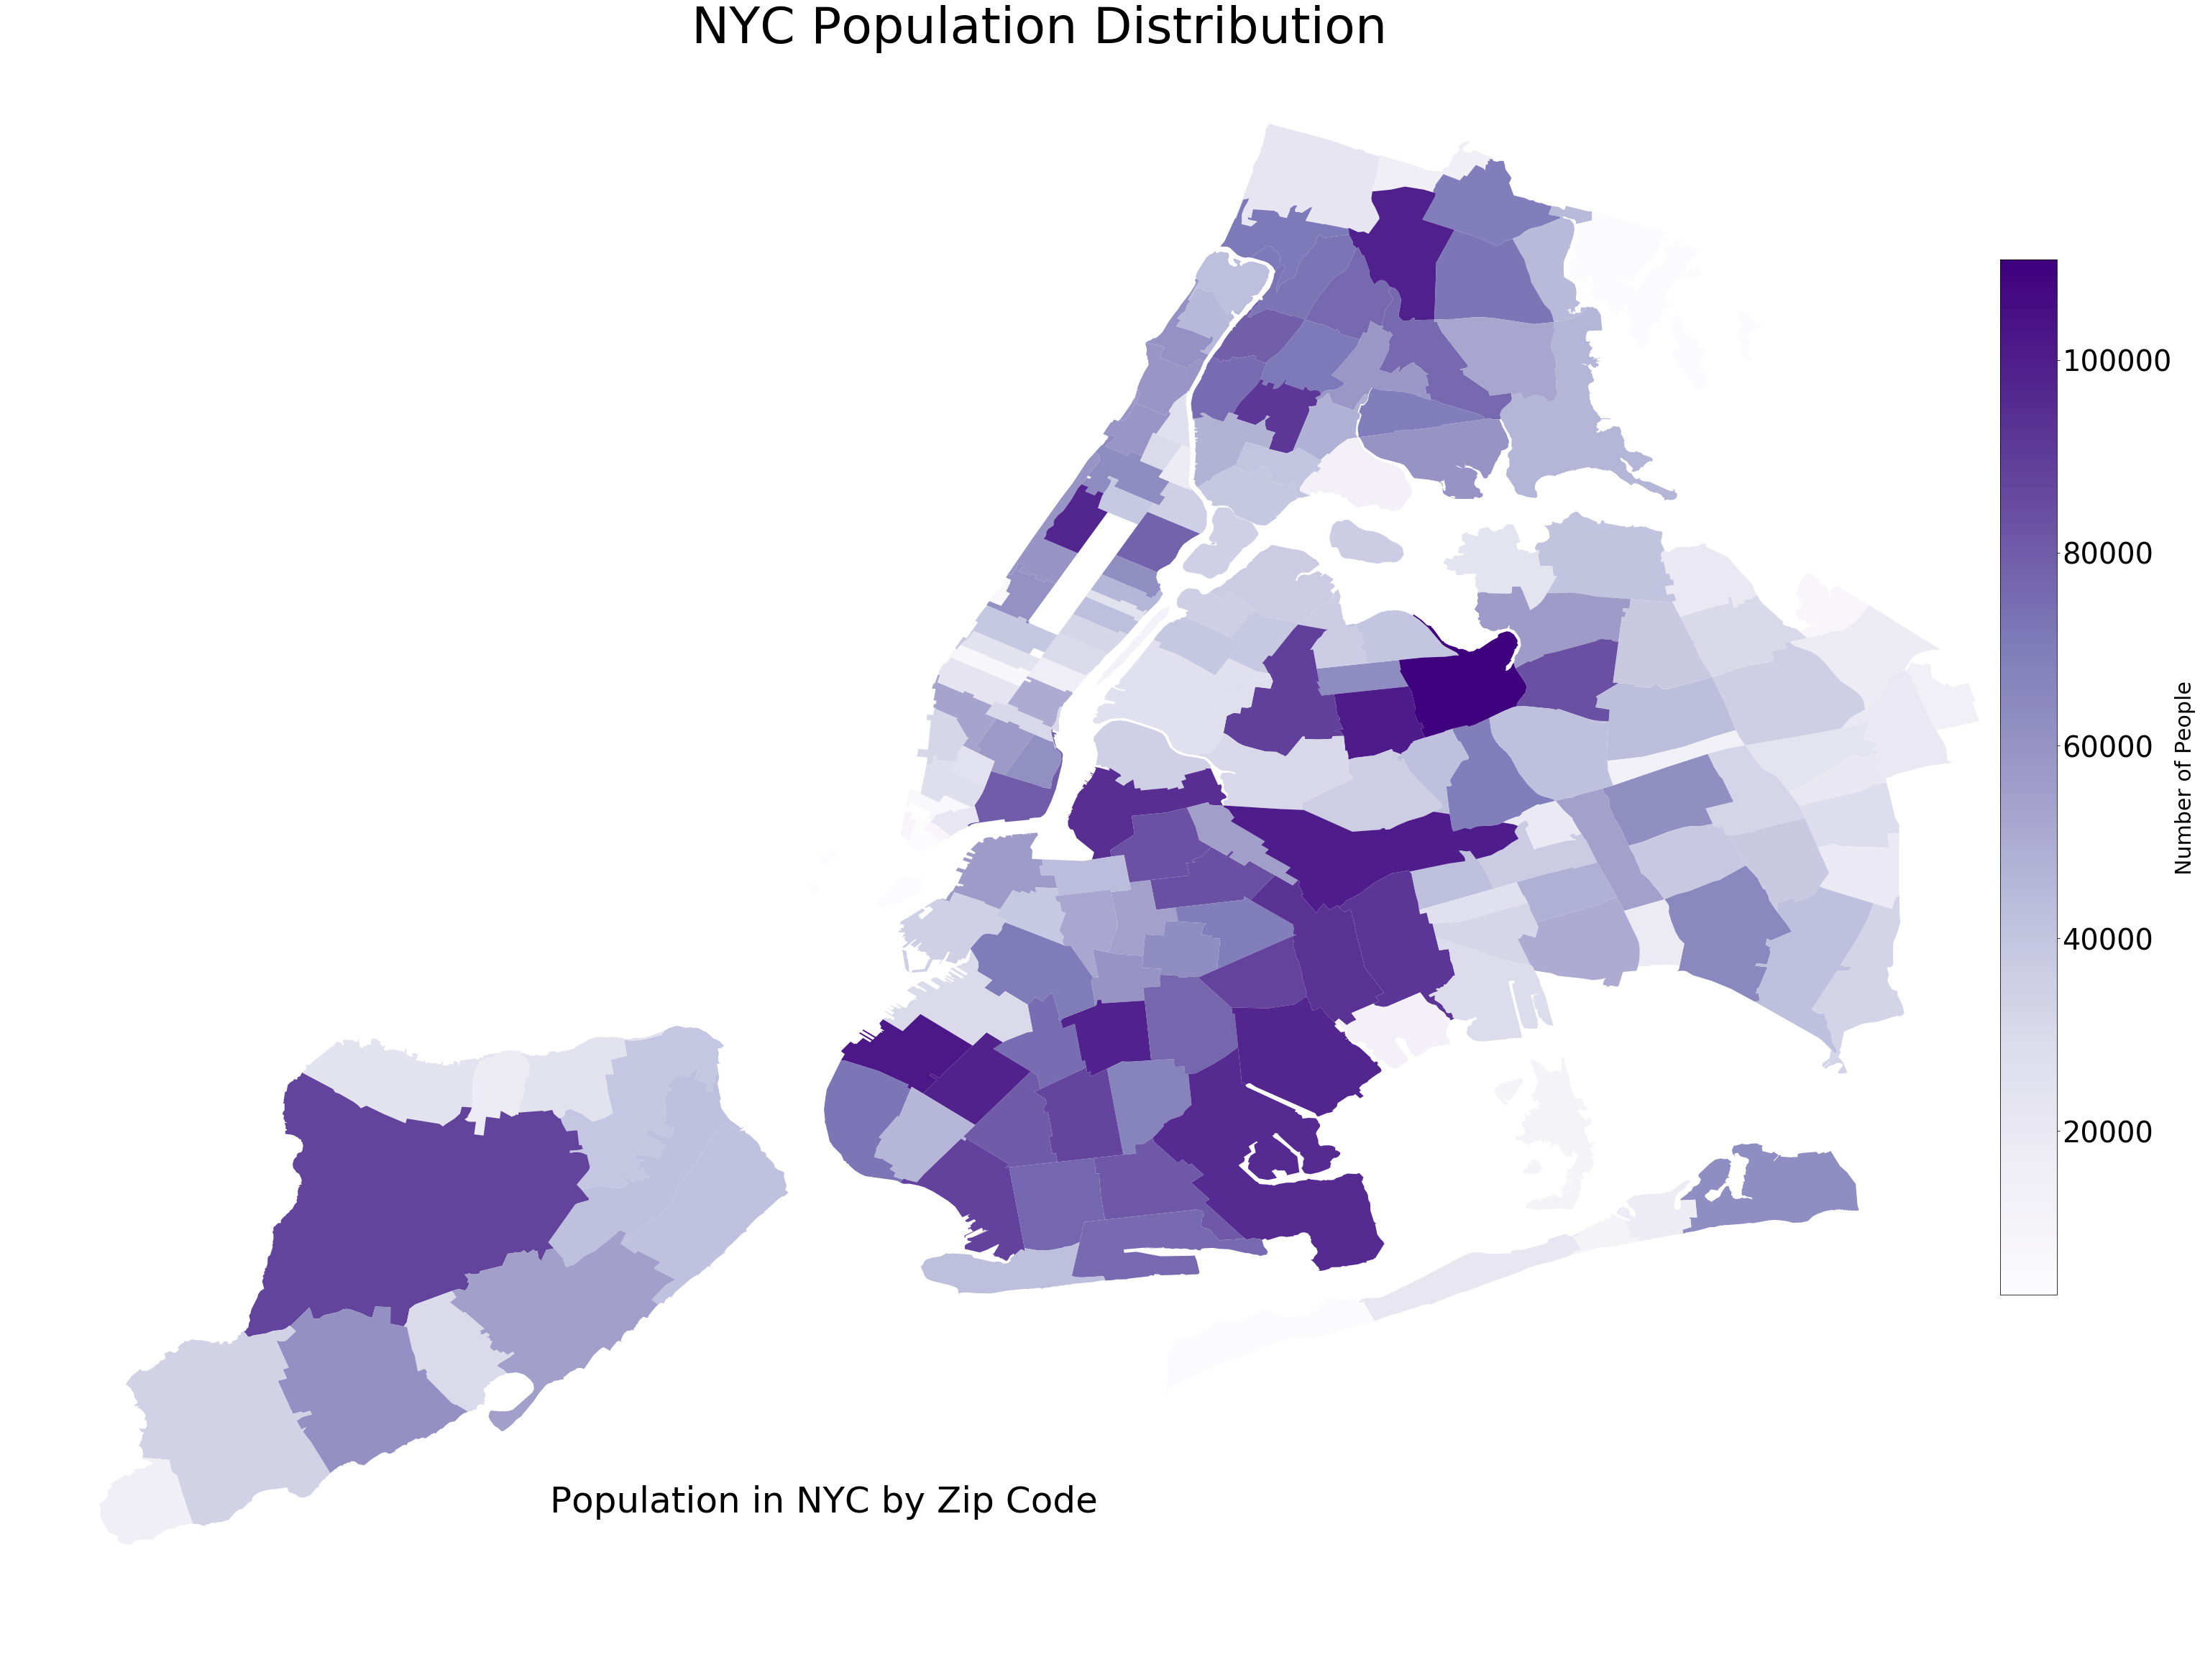

In [416]:
column = 'Population'
fig, ax = plt.subplots(figsize = (55,40))
vmin = geo_merge[column].min()
vmax = geo_merge[column].max()
geo_merge.plot(ax=ax,column = column,cmap='Purples',legend = False)
ax.set_title("NYC Population Distribution", fontdict={'fontsize': 70}, loc='center')
ax.annotate("Population in NYC by Zip Code", xy=(0.25, .1), size=50, xycoords='figure fraction')
# plt.xlim([6,19])
# plt.ylim([36,47.7])
plt.xticks([], [])
plt.yticks([], [])

cax = fig.add_axes([.85, 0.28, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.set_label('Number of People', size=30)
cbr.ax.tick_params(labelsize=40) 
ax.set_axis_off()
plt.savefig('population.png',format = 'png',bbox_inches='tight')

## Number of covid cases in each zip code (does not account for population density)

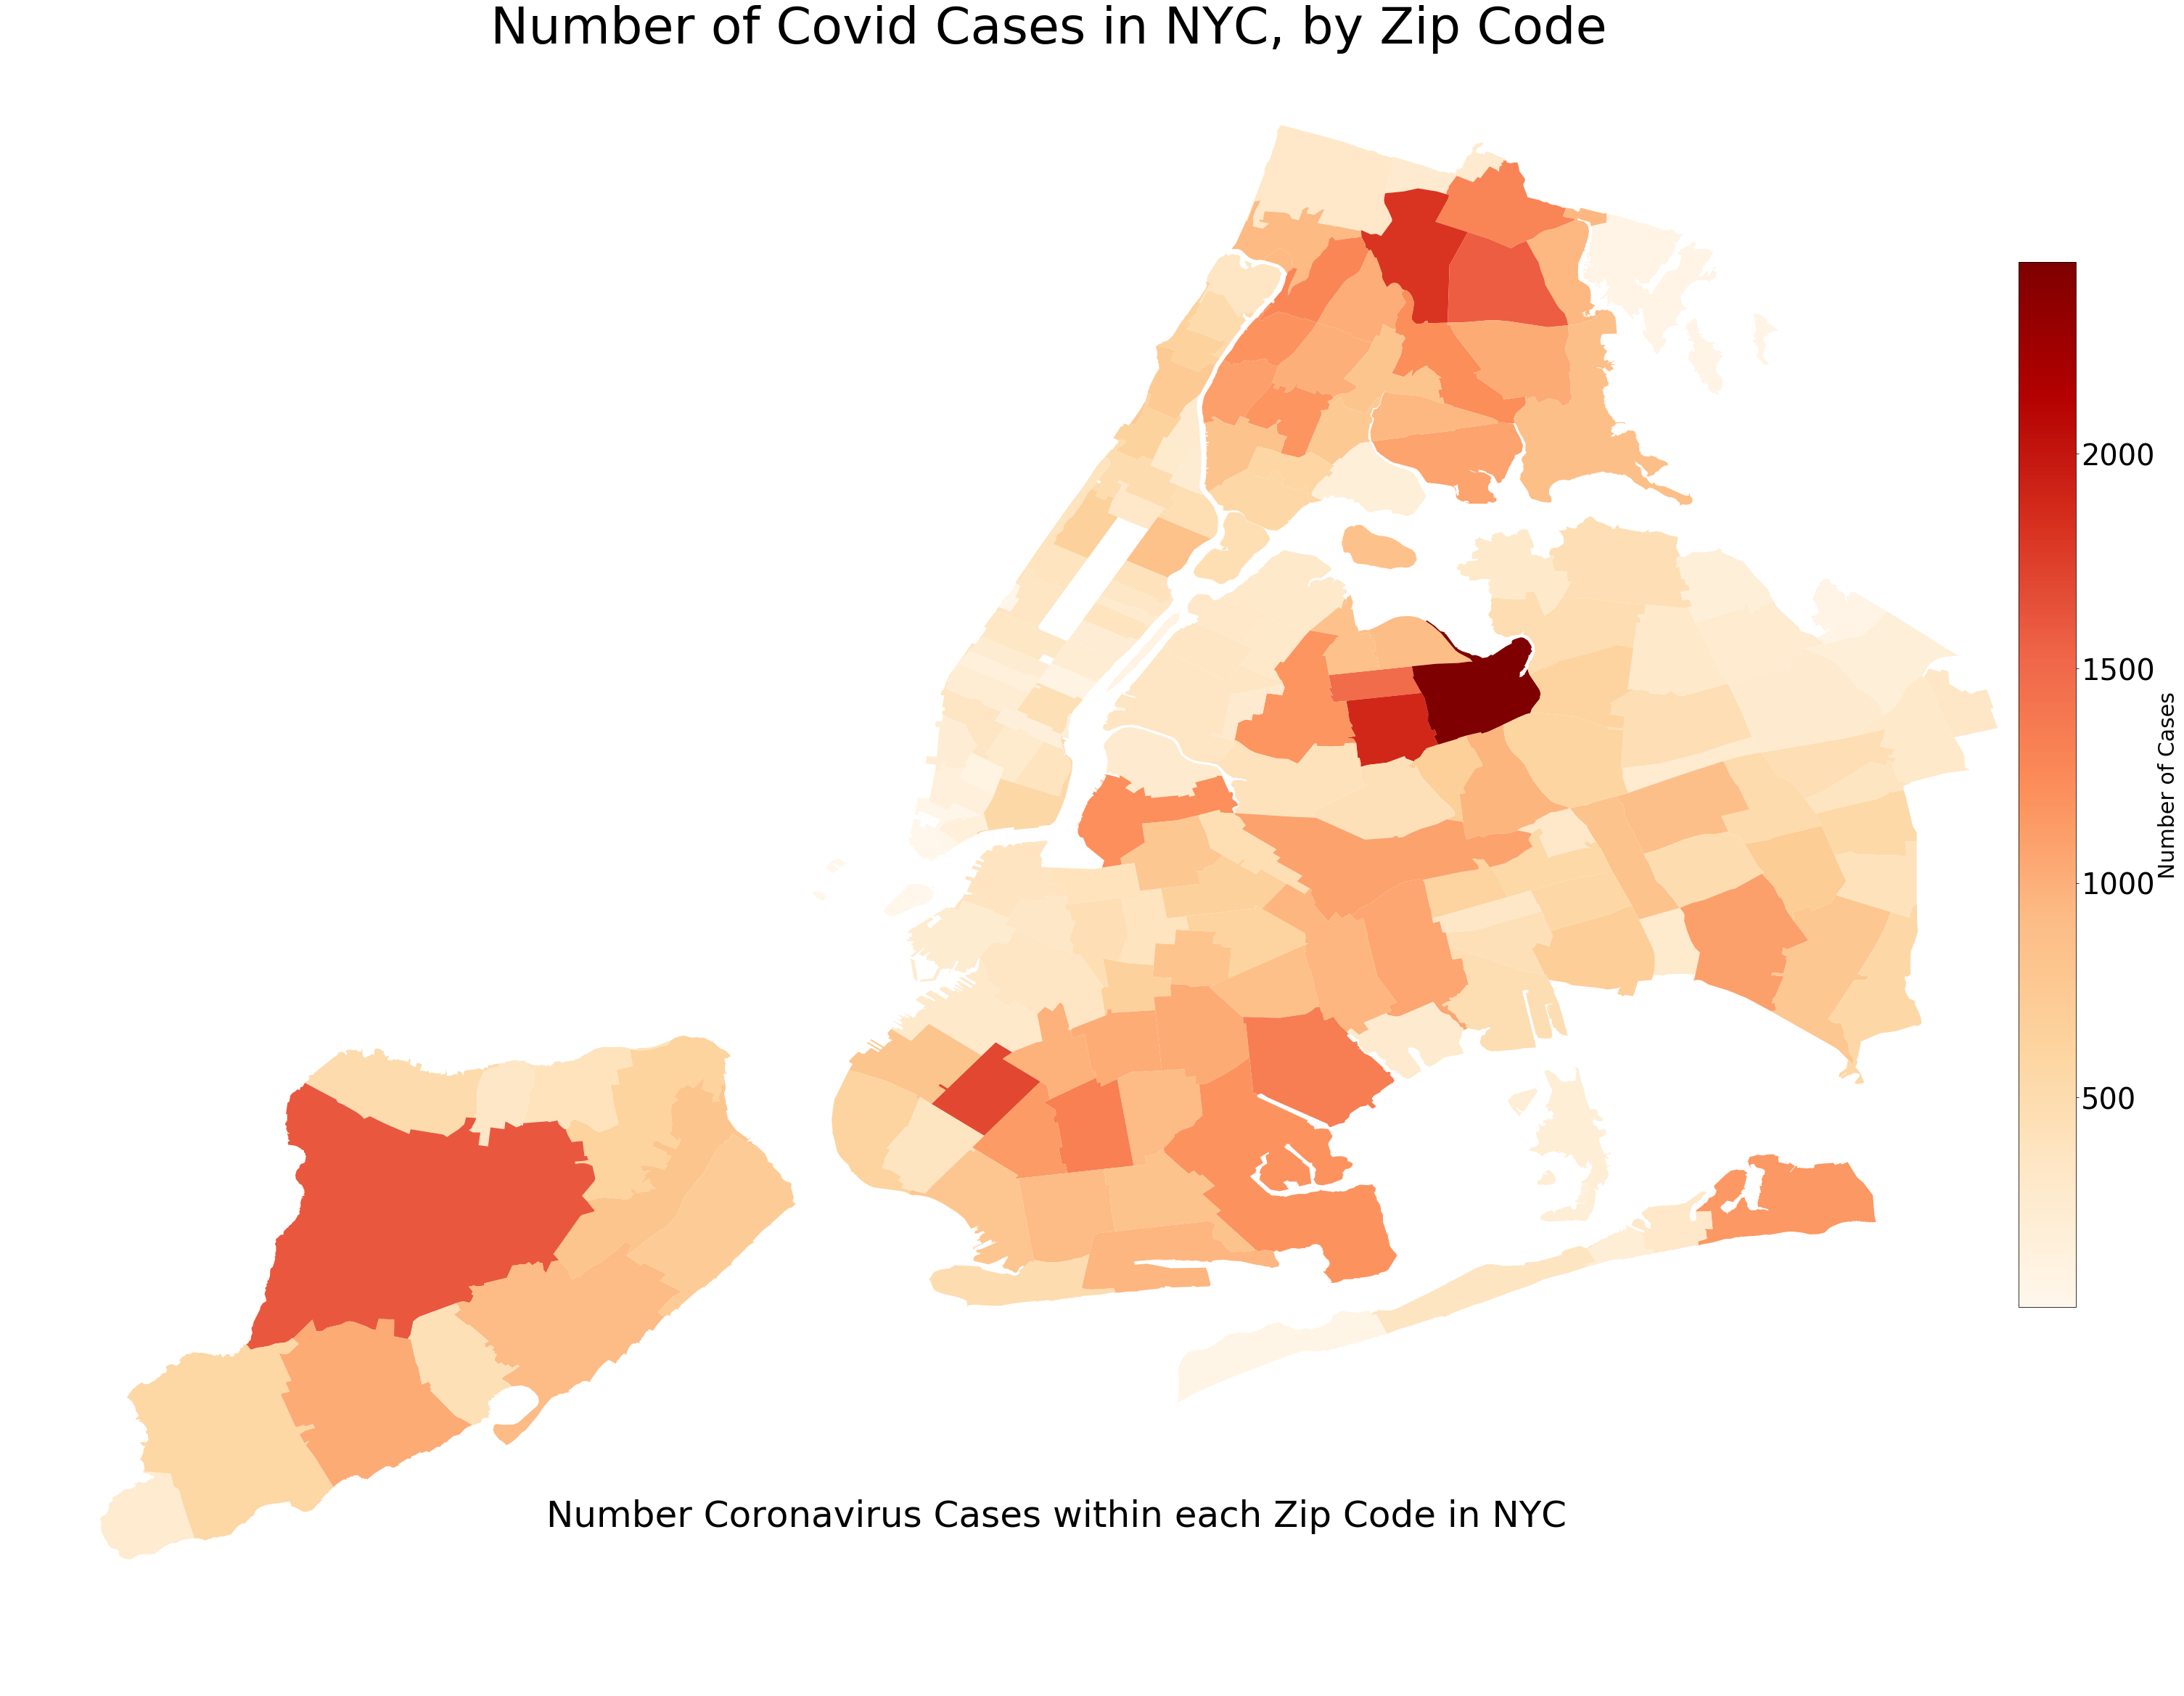

In [474]:
column = '#Positive'
fig, ax = plt.subplots(figsize = (55,40))
vmin = geo_merge[column].min()
vmax = geo_merge[column].max()
geo_merge.plot(ax=ax,column = column,cmap='OrRd',legend = False)
ax.set_title("Number of Covid Cases in NYC, by Zip Code", fontdict={'fontsize': 70}, loc='center')
ax.annotate("Number Coronavirus Cases within each Zip Code in NYC", xy=(0.25, .1), size=50, xycoords='figure fraction')
# plt.xlim([6,19])
# plt.ylim([36,47.7])
plt.xticks([], [])
plt.yticks([], [])

cax = fig.add_axes([.85, 0.28, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.set_label('Number of Cases', size=30)
cbr.ax.tick_params(labelsize=40) 
ax.set_axis_off()
plt.savefig('numCases.png',format = 'png',bbox_inches='tight')

## Percent of zip code that has been tested
### ToDo:  take outliers out of this

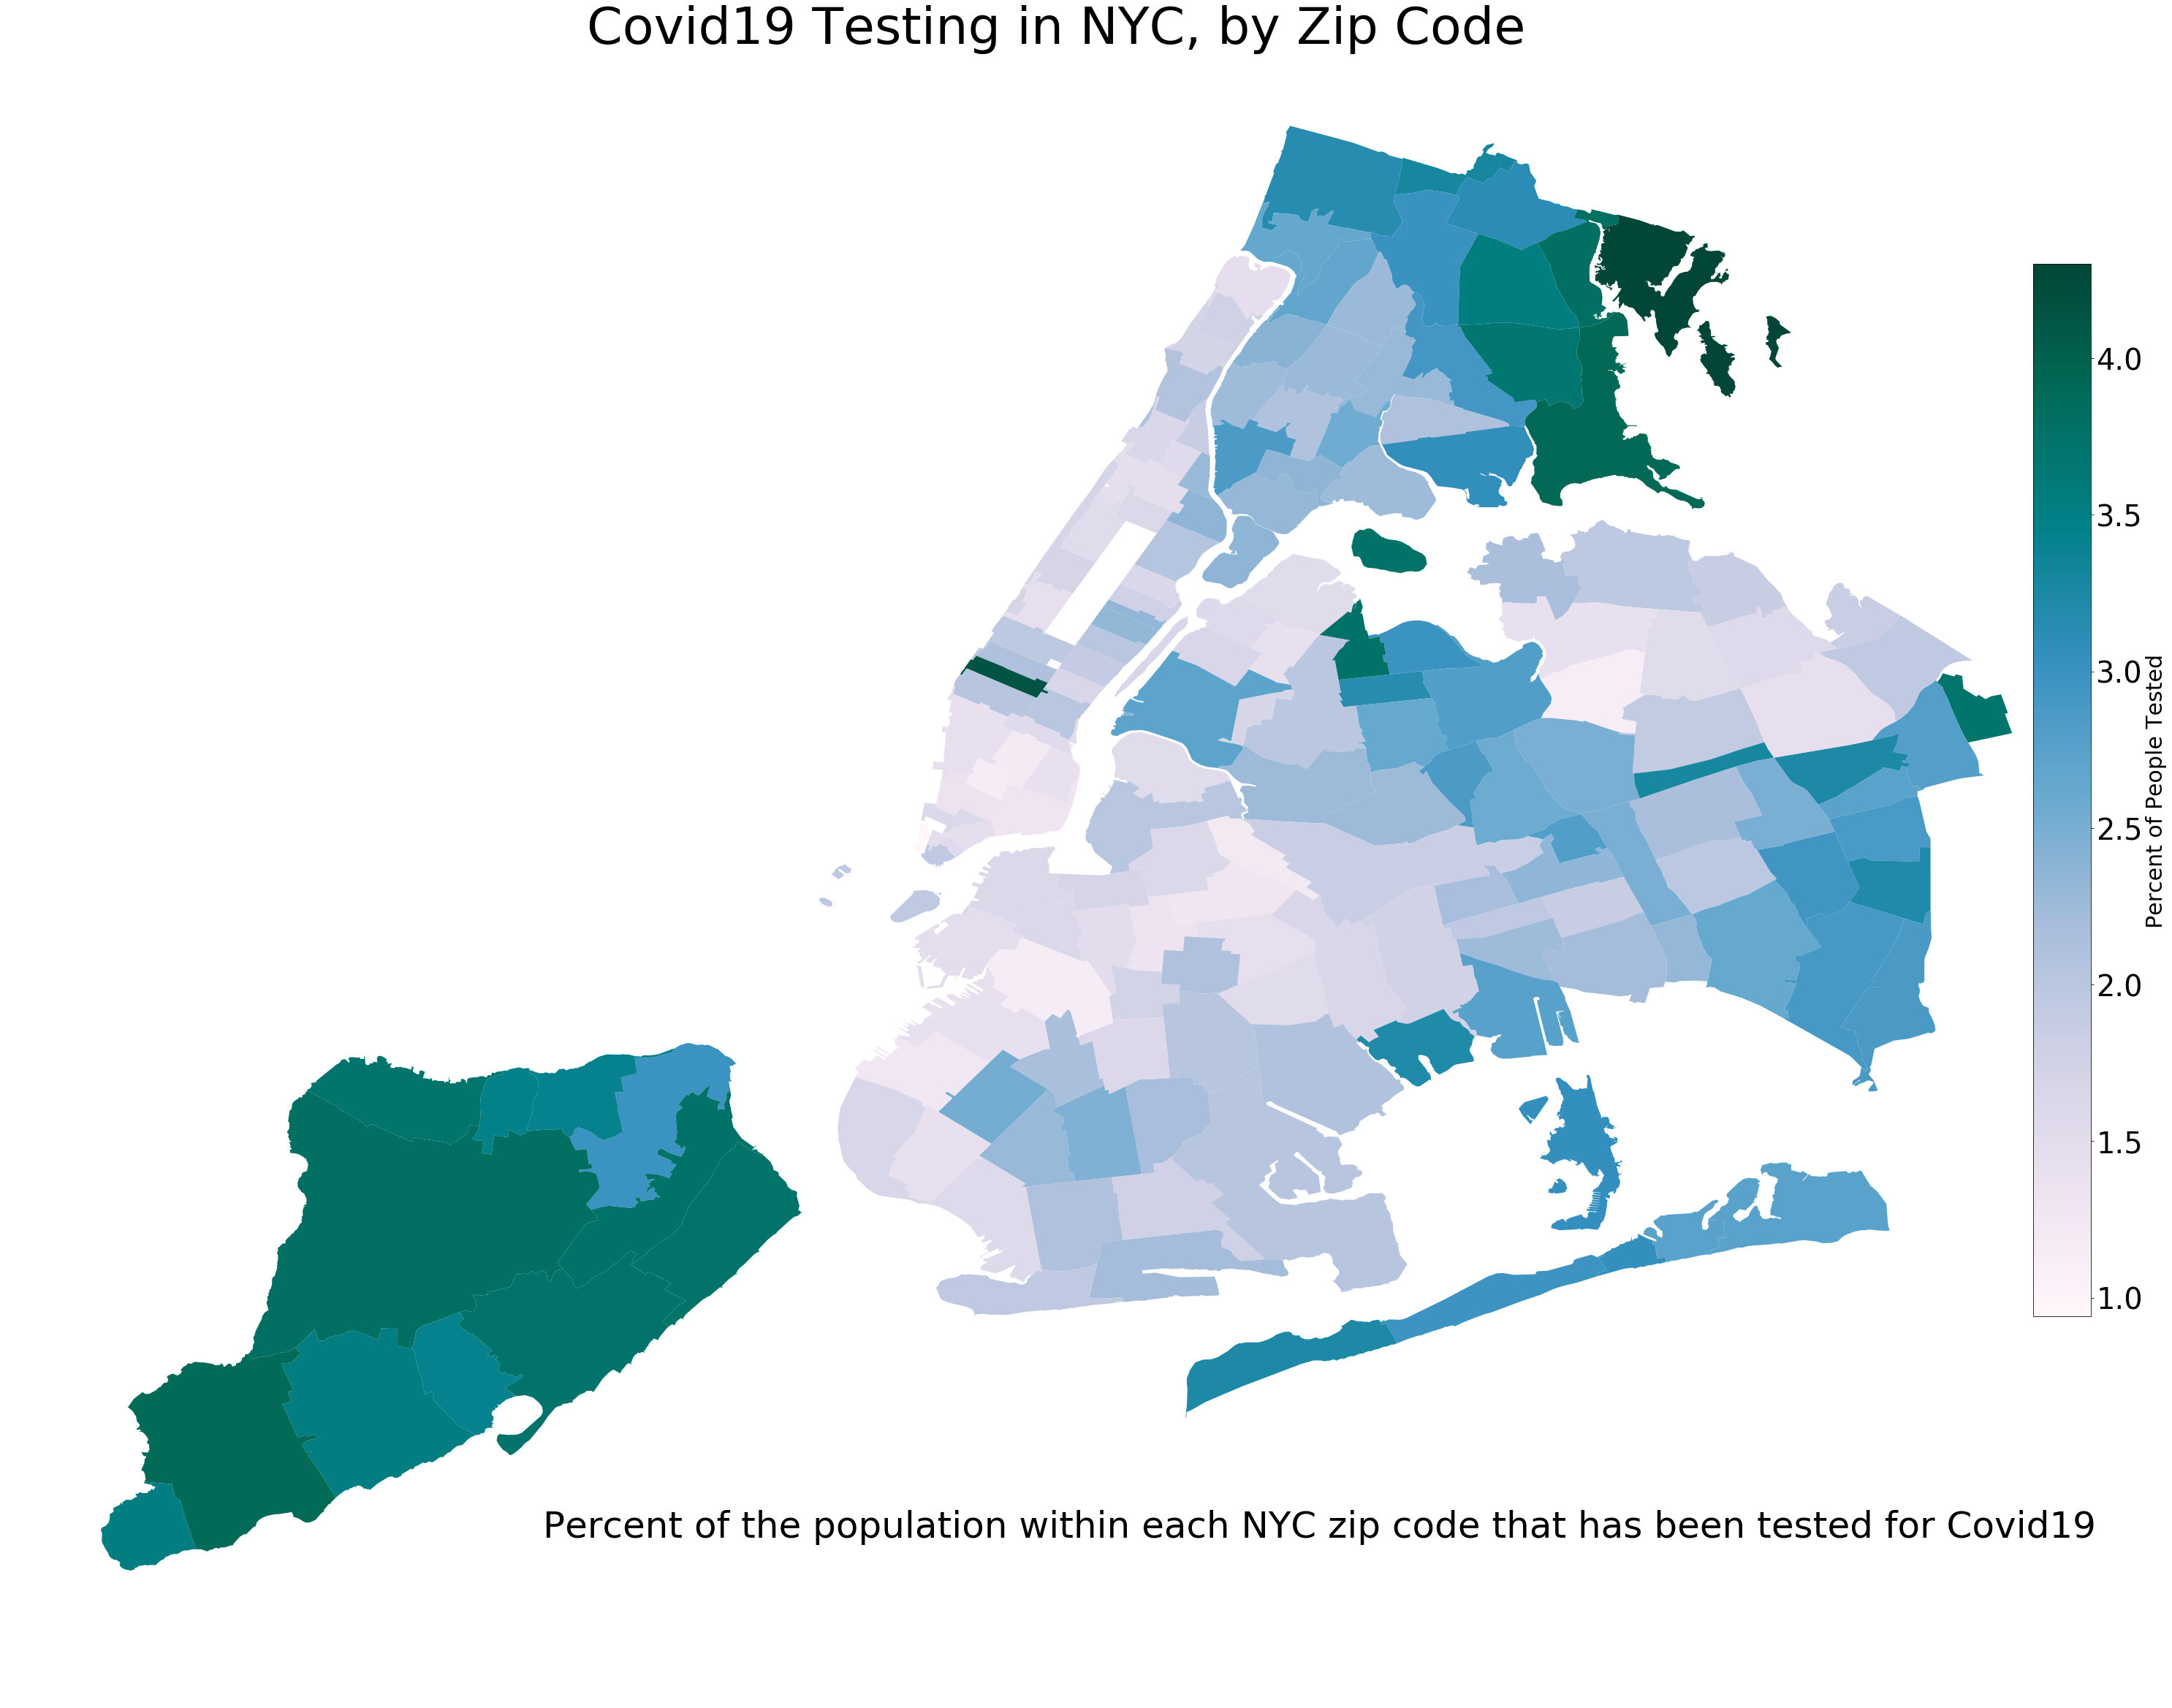

In [478]:
fig, ax = plt.subplots(figsize = (55,40))
vmin = geo_merge['PercentPopTested'].min()
vmax = geo_merge['PercentPopTested'].max()
geo_merge.plot(ax=ax,column = 'PercentPopTested',cmap='PuBuGn',legend = False)
ax.set_title("Covid19 Testing in NYC, by Zip Code", fontdict={'fontsize': 70}, loc='center')
ax.annotate("Percent of the population within each NYC zip code that has been tested for Covid19", xy=(0.25, .1), size=50, xycoords='figure fraction')
# plt.xlim([6,19])
# plt.ylim([36,47.7])
plt.xticks([], [])
plt.yticks([], [])

cax = fig.add_axes([.85, 0.28, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap='PuBuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.set_label('Percent of People Tested', size=30)
cbr.ax.tick_params(labelsize=40) 
ax.set_axis_off()
plt.savefig('percentTested.png',format = 'png',bbox_inches='tight')

## Percent of zip code that tested POSITIVE for Covid19

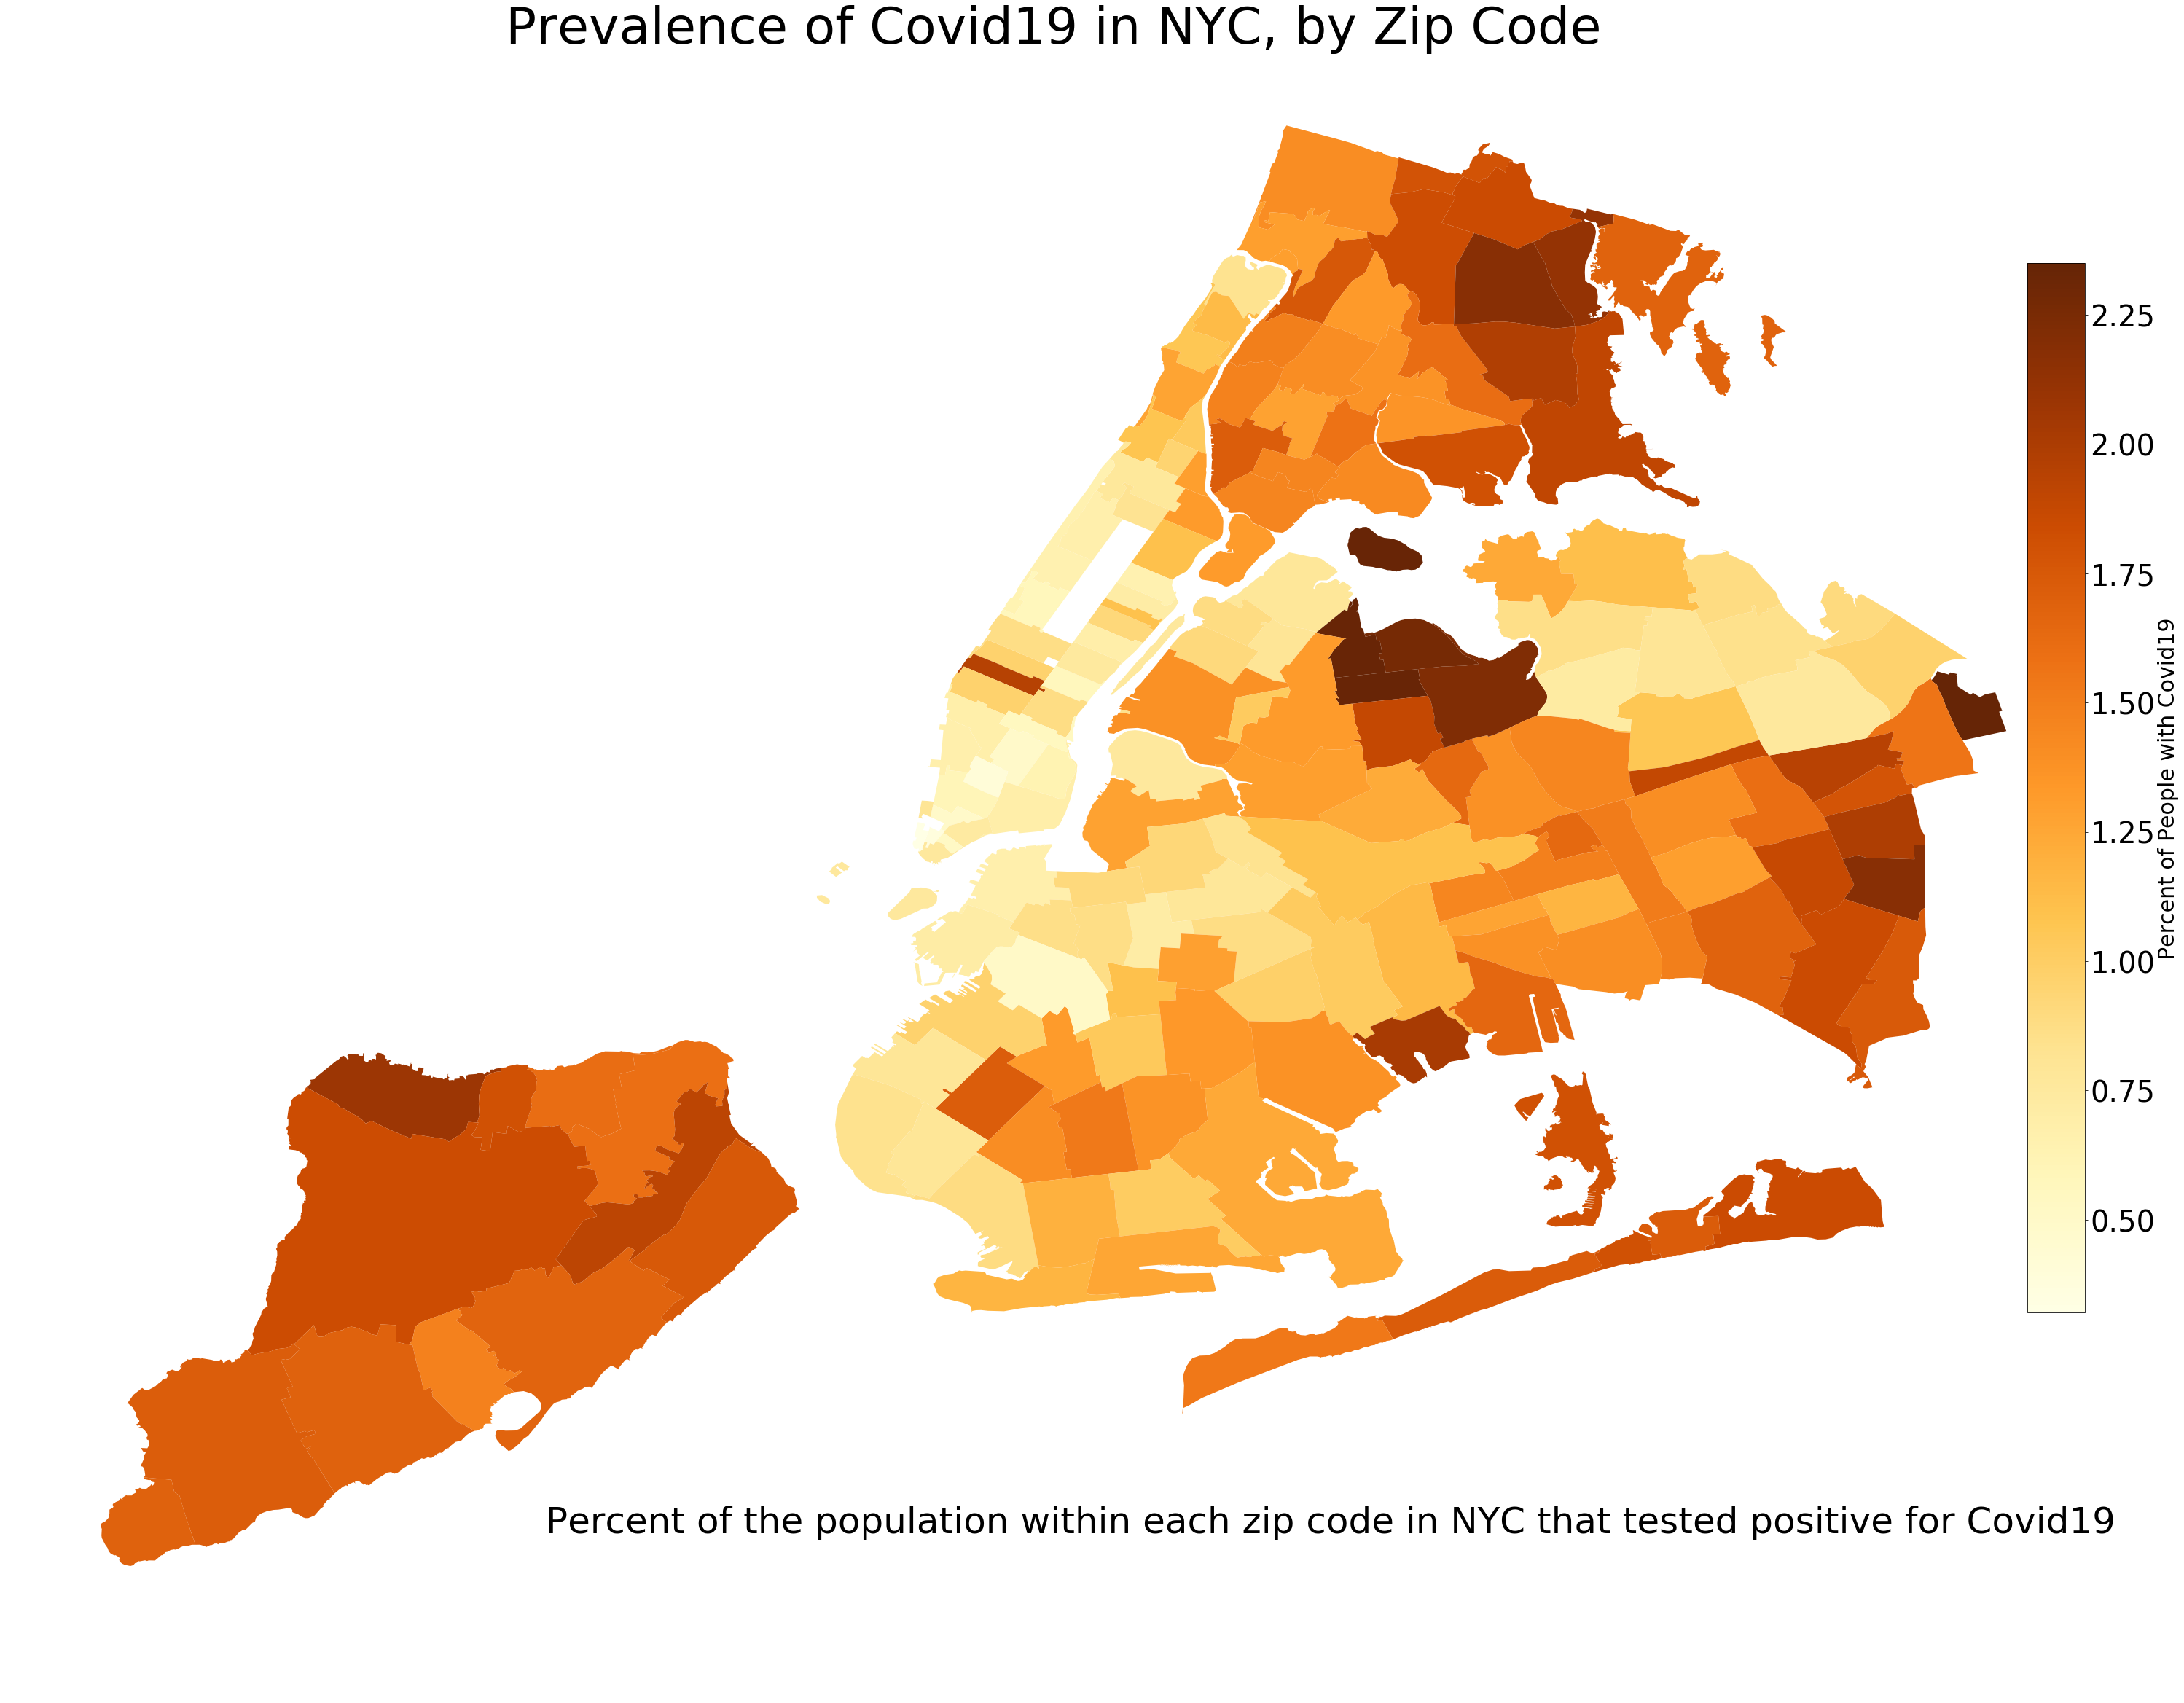

In [473]:
column = 'PercentPopPositive'
fig, ax = plt.subplots(figsize = (55,40))
vmin = geo_merge[column].min()
vmax = geo_merge[column].max()
geo_merge.plot(ax=ax,column = column,cmap='YlOrBr',legend = False)
ax.set_title("Prevalence of Covid19 in NYC, by Zip Code", fontdict={'fontsize': 70}, loc='center')
ax.annotate("Percent of the population within each zip code in NYC that tested positive for Covid19", xy=(0.25, .1), size=50, xycoords='figure fraction')
# plt.xlim([6,19])
# plt.ylim([36,47.7])
plt.xticks([], [])
plt.yticks([], [])

cax = fig.add_axes([.85, 0.28, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.set_label('Percent of People with Covid19', size=30)
cbr.ax.tick_params(labelsize=40) 
ax.set_axis_off()
plt.savefig('percentPos.png',format = 'png',bbox_inches='tight')

## Percent of administered tests that were positive

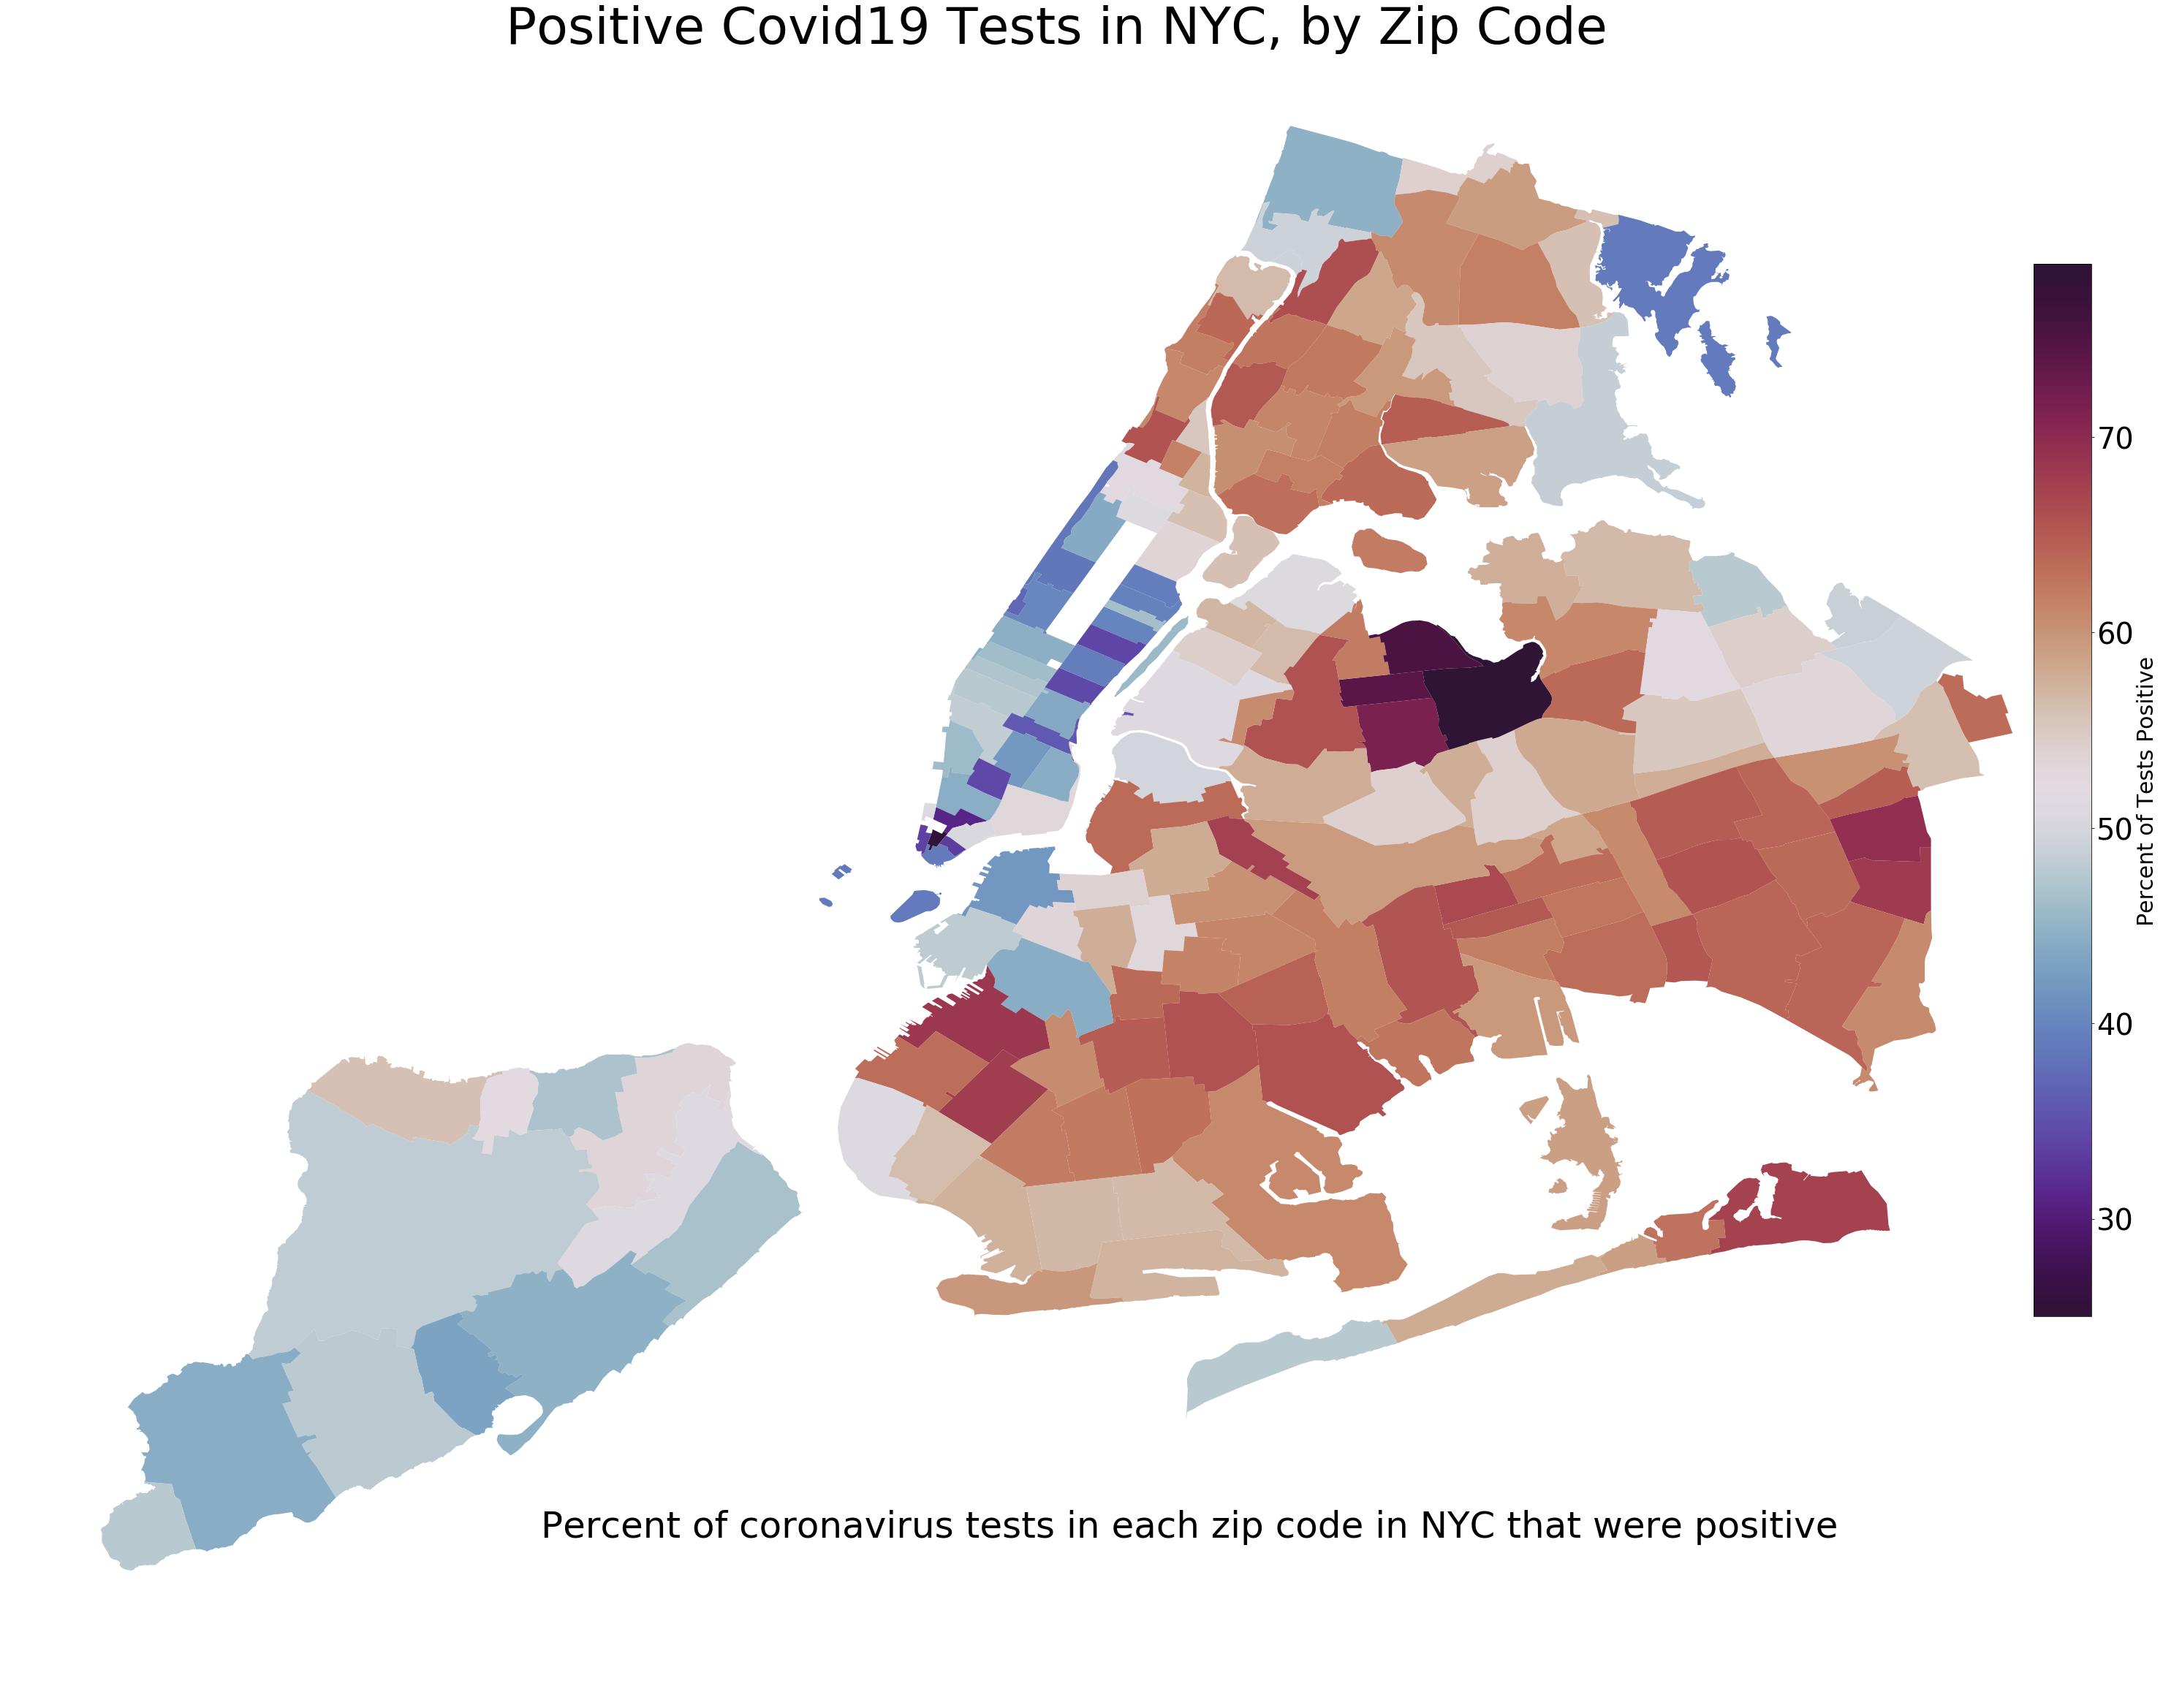

In [457]:
column = 'PercentPosTests'
fig, ax = plt.subplots(figsize = (55,40))
vmin = geo_merge[column].min()
vmax = geo_merge[column].max()
geo_merge.plot(ax=ax,column = column,cmap='twilight_shifted',legend = False)
ax.set_title("Positive Covid19 Tests in NYC, by Zip Code", fontdict={'fontsize': 70}, loc='center')
ax.annotate("Percent of coronavirus tests in each zip code in NYC that were positive", xy=(0.25, .1), size=50, xycoords='figure fraction')
# plt.xlim([6,19])
# plt.ylim([36,47.7])
plt.xticks([], [])
plt.yticks([], [])

cax = fig.add_axes([.85, 0.28, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap='twilight_shifted', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.set_label('Percent of Tests Positive', size=30)
cbr.ax.tick_params(labelsize=40) 
ax.set_axis_off()
plt.savefig('percentPosTests.png',format = 'png',bbox_inches='tight')